In [87]:
from src.codeGameSimulation.GameUr import GameUr, Player, Dice, GameSettings
import gameBoardDisplay as gbd

from fractions import Fraction

import locale

import numpy as np

from helpers import colorboxplot, makeVlines, zeichneErrechnetenWert, drawGame, colors
from src.codeGameSimulation.store2db import getDataFromDB, getGameFromDB, getGSFromDB

# %config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import matplotlib.ticker as mt

locale.setlocale(locale.LC_NUMERIC, "german")

mplstyle.use("fast")
mplstyle.use("default")
# mpl.rcParams['figure.figsize'] = [20, 10]
import sqlite3


In [70]:
db_dir = "D:/Uni/BA/data/"
db_filename = "gameHistories_baseline_two_players"


In [71]:
ids,roundCounts, stepCounts, winners, settingsIDs = getDataFromDB(db_dir, db_filename)
gs_unordered = getGSFromDB(db_dir,db_filename)
print([len(id) for id in ids])

db load finished after 0:00:07.756391
sort finished after 0:00:00.112024
groupby finished after 0:00:00.125029
sort finished after 0:00:00.478107
split finished after 0:00:04.288970
settings loaded
[1500000]


In [72]:
labels_unordered = [" vs ".join([p.getStrategy().getName(
)+" [{}]".format(p.getStoneCount()) for p in gs_.getPlayers()]) for gs_ in gs_unordered]
labels = [labels_unordered[i] for i in settingsIDs]
gameSettings = [gs_unordered[i] for i in settingsIDs]
labels



['random [7] vs random [7]']

7


Text(0.5, 0, 'empirisch bestimmte Spiellänge in Runden')

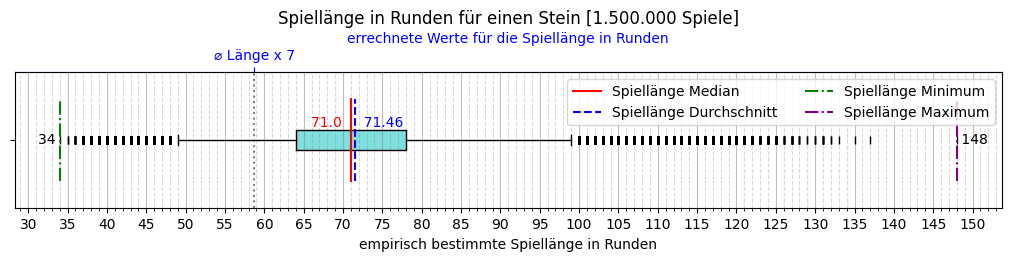

In [73]:
rc = roundCounts[0]
figRounds7s, ax = plt.subplot_mosaic([["Boxplots Runden"]], figsize=[
    10, 2.5], layout="constrained")
# ax2 = plt.twinx(ax["Boxplots Runden"])
# makeHistogram(ax2,[rc],[""],colors[0],fill=False)
# ax2.set_ylabel("Wahrschenlichkeit")
zeichneErrechnetenWert(ax["Boxplots Runden"], "r",7)

colorboxplot([rc], ax["Boxplots Runden"], [""], colors[0])
ax["Boxplots Runden"].set_title(
    "Spiellänge in Runden für einen Stein [{0:n} Spiele]".format(len(rc), grouping=True))
ax["Boxplots Runden"].set_xlabel('empirisch bestimmte Spiellänge in Runden')


In [74]:
rc = roundCounts[0]
roundInfo={"⌀": np.mean(rc), "min": np.min(rc), "max": np.max(rc),
 "p1": np.percentile(rc, 1),
 "p25": np.percentile(rc, 25),
 "p50": np.percentile(rc, 50),
 "p75": np.percentile(rc, 75),
 "p99": np.percentile(rc, 99),
 "min_count": rc.count(np.min(rc)),
 "max_count": rc.count(np.max(rc)),
 }
roundInfo


{'⌀': 71.46035933333333,
 'min': 34,
 'max': 148,
 'p1': 49.0,
 'p25': 64.0,
 'p50': 71.0,
 'p75': 78.0,
 'p99': 99.0,
 'min_count': 1,
 'max_count': 1}

### Schritte

7


Text(0.5, 1.0, 'Spiellänge in Schritten für sieben Steine [1.500.000 Spiele]')

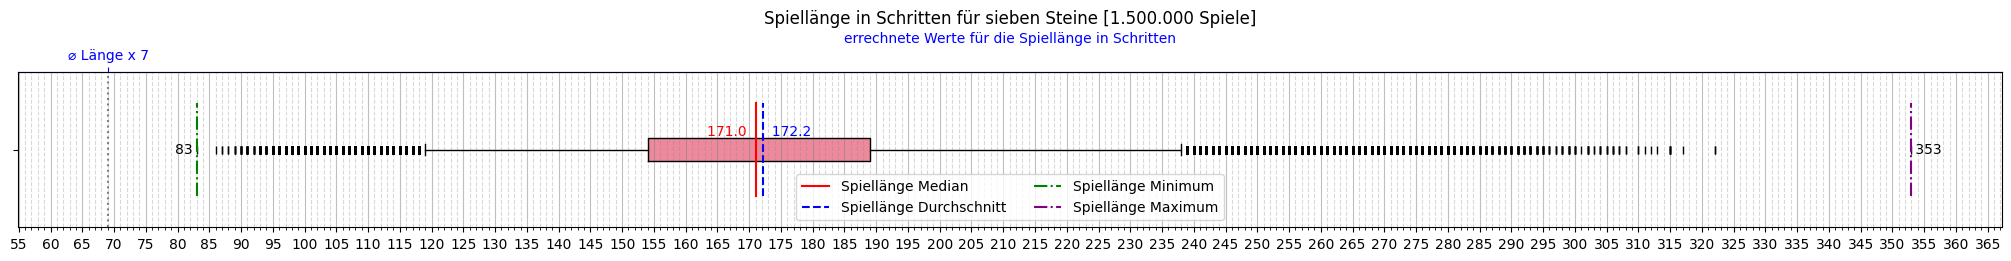

In [75]:
sc = stepCounts[0]
figSteps7s, ax = plt.subplot_mosaic([["Boxplots Schritte"]], figsize=[
    20, 2.5], layout="constrained")
zeichneErrechnetenWert(ax["Boxplots Schritte"], "s", 7)
colorboxplot([sc], ax["Boxplots Schritte"], [""], [colors[0]])
ax["Boxplots Schritte"].set_title(
    "Spiellänge in Schritten für sieben Steine [{0:n} Spiele]".format(len(sc), grouping=True))


## typischer Spielverlauf

ID für Spiel mit durchschnittlicher Länge: 30
Daten geladen


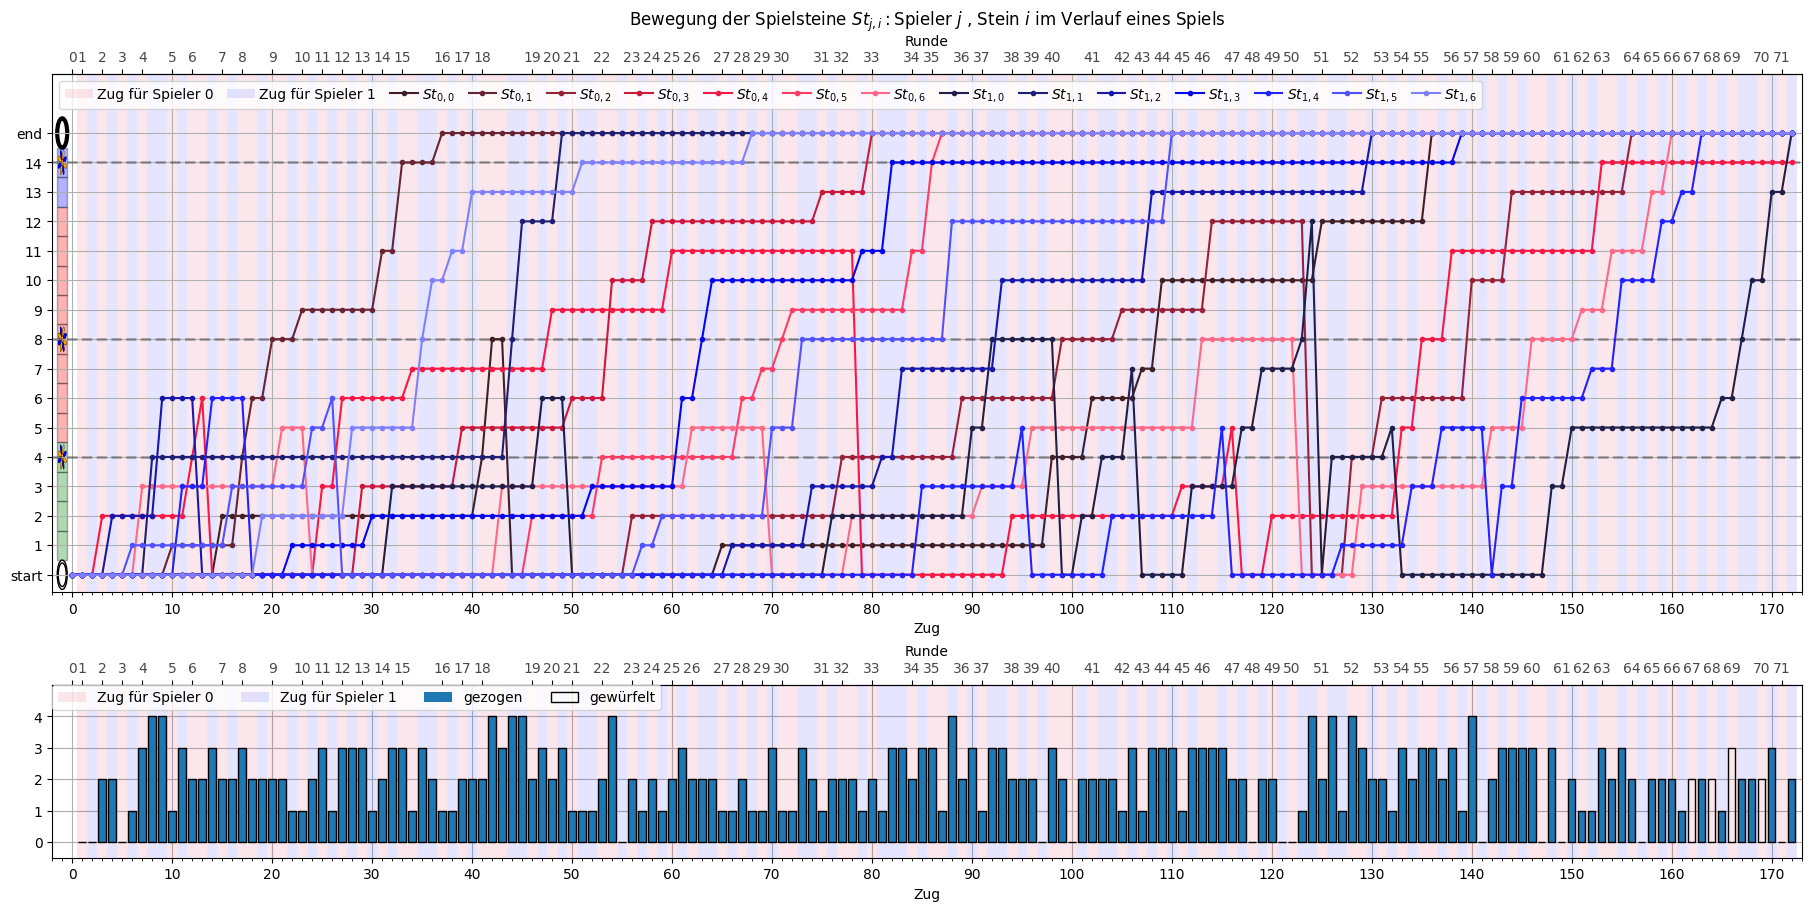

In [76]:
gameIDAvg = rc.index(int(np.round(roundInfo["⌀"])))

print("ID für Spiel mit durchschnittlicher Länge:", ids[0][gameIDAvg])
gameAvg = getGameFromDB(ids[0][gameIDAvg], db_dir, db_filename)
print("Daten geladen")
figMovement = drawGame(gameAvg, gameSettings[0],figsize =[18,9])


### Auswertung geworfen worden und verlorene Distanz

In [77]:
throwCount = [0,0]
throwDistance = [0, 0]
for p_i,p in enumerate(gameAvg["stones"]):
    for s in gameAvg["stones"][p]:
        tc =sum([x < gameAvg["stones"][p][s][max([0, i-1])] for i, x in enumerate(gameAvg["stones"][p][s])])
        td = sum([(x < gameAvg["stones"][p][s][max([0, i-1])])*(x - gameAvg["stones"][p][s][max([0, i-1])]) for i, x in enumerate(gameAvg["stones"][p][s])])
        throwCount[p_i] += tc
        throwDistance[p_i] += td


print("Anzahl geworfen worden:\nSpieler 0: {}\nSpieler 1: {}\n\nverlorene Distanz: \nSpieler 0: {}\nSpieler 1: {}".format(*throwCount, *throwDistance))


Anzahl geworfen worden:
Spieler 0: 8
Spieler 1: 11

verlorene Distanz: 
Spieler 0: -60
Spieler 1: -71


## Das kürzeste Spiel in der Simulation

ID für Spiel mit minimaler Länge: 1330496
Daten geladen


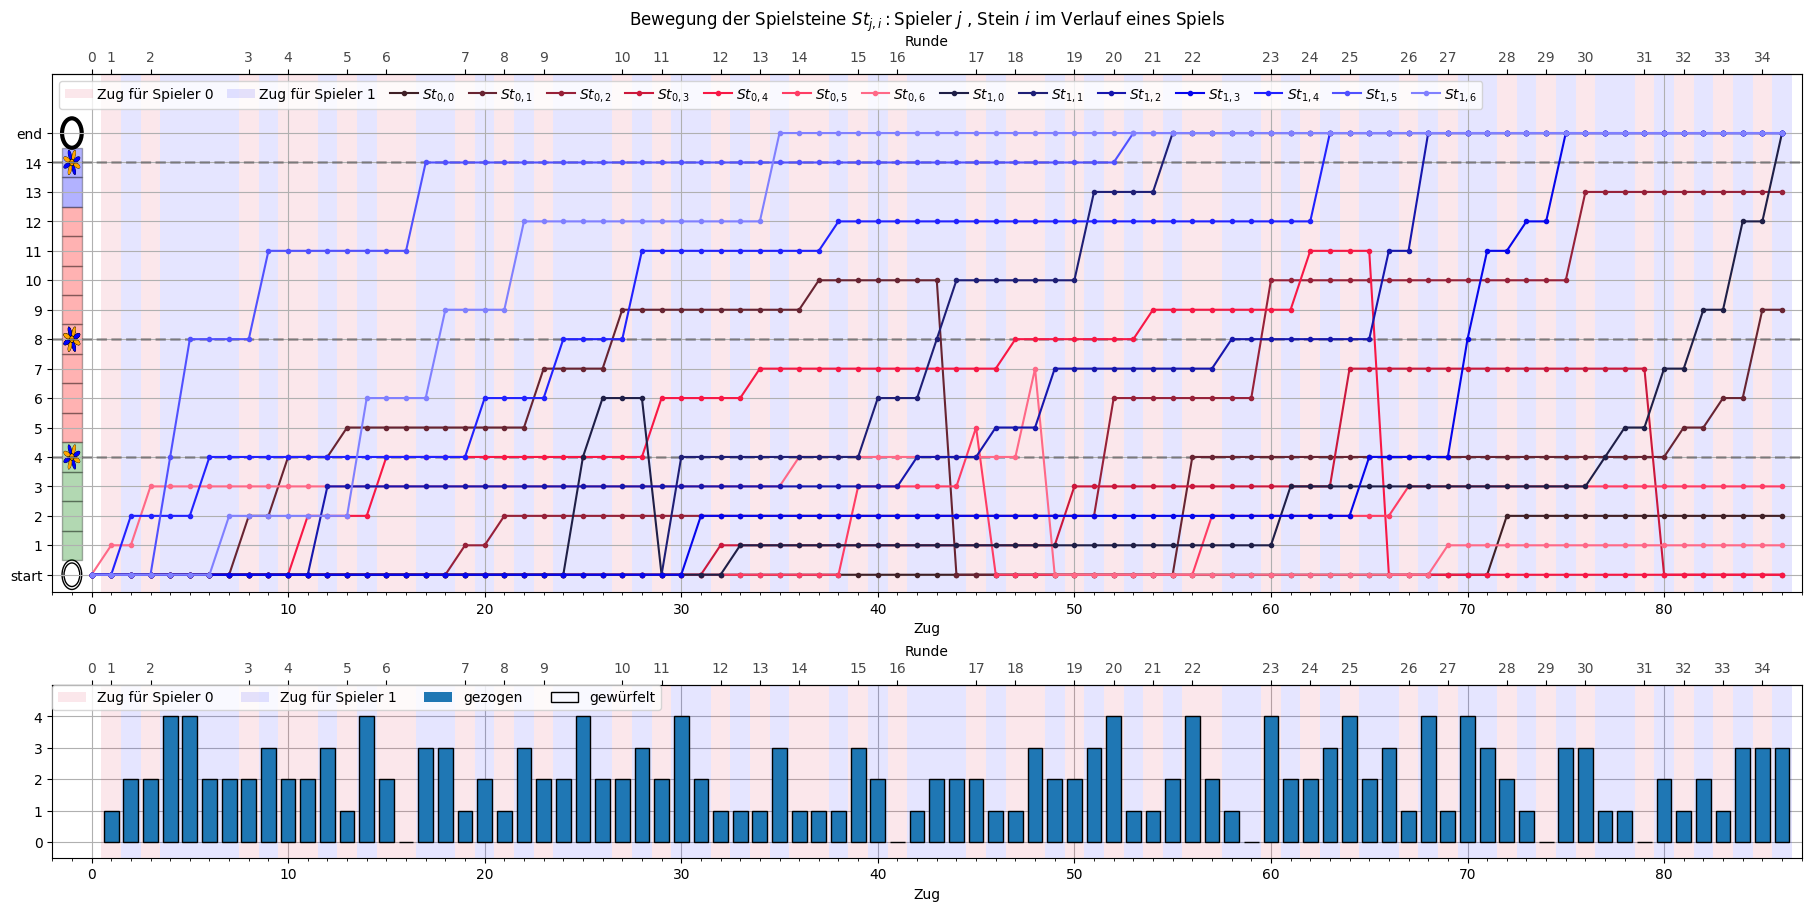

In [78]:
gameIDMin = rc.index(int(np.round(roundInfo["min"])))

print("ID für Spiel mit minimaler Länge:", ids[0][gameIDMin])
gameMin = getGameFromDB(ids[0][gameIDMin], db_dir, db_filename)
print("Daten geladen")
figMovement = drawGame(gameMin, gameSettings[0],figsize =[18,9])

## Wer gewinnt?

[51.13473333333334]
[48.86526666666667]


C:\Users\walli\AppData\Local\Temp/ipykernel_28660/2442361079.py:52: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


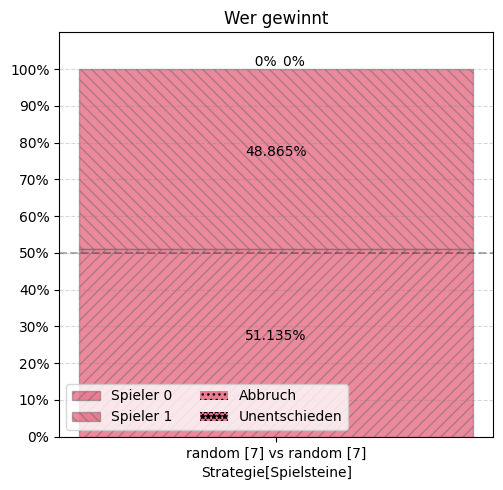

In [101]:
def wer_gewinnt(winners, figsize=[15, 5]):

    player0 = [s.count(["p0"]) / len(s) * 100 for s in winners]
    player1 = [s.count(["p1"]) / len(s) * 100 for s in winners]
    no_one = [s.count([]) / len(s) * 100 for s in winners]
    both = [s.count(["p0", "p1"]) / len(s) * 100 for s in winners]
    print(player0)
    print(player1)

    fig, ax = plt.subplots(figsize=figsize, layout="constrained")
    # hat_graph(ax, xlabels, [player0, player1], ['Player 0', 'Player 1'])

    p0 = ax.bar(
        labels,
        player0,
        label="Spieler 0",
        alpha=0.5,
        width=0.5,
        color=colors[0],
        hatch="///",
        edgecolor="dimgray",
    )
    p1 = ax.bar(
        labels,
        player1,
        label="Spieler 1",
        alpha=0.5,
        width=0.5,
        bottom=player0,
        color=colors,
        hatch="\\\\\\",
        edgecolor="dimgray",
    )
    ab = ax.bar(labels, no_one, label="Abbruch", alpha=.5, width=.5, color=colors,
                hatch="...", bottom=[sum(x) for x in zip(player0, player1)])
    ev = ax.bar(labels, both, label="Unentschieden", alpha=.5, width=.5, color=colors,
                hatch="***", bottom=[sum(x) for x in zip(player0, player1, no_one)])

    ax.bar_label(p0, label_type="center", fmt="%3.5g%%", padding=5)
    ax.bar_label(p1, label_type="center", fmt="%3.5g%%", padding=5)
    ax.bar_label(ab, label_type='center', fmt="      %3.5g%%", padding=5)
    ax.bar_label(ev, label_type='center',fmt="%3.5g%%       ", padding=5)


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Strategie[Spielsteine]")
    ax.set_title("Wer gewinnt")
    # ax.legend( loc='lower center', ncol=2)
    ax.legend(loc="lower left", ncol=2)
    ax.axhline(50, color=(0, 0, 0, 0.3), ls="--")

    fig.tight_layout()
    ax.set_yticks(np.linspace(0, 100, 11))

    ax.set_ylim(0,110)
    ax.yaxis.set_major_formatter(mt.PercentFormatter())
    ax.grid(axis="y", color=("gray"), alpha=0.3, ls="--")
    plt.show()

wer_gewinnt(winners,[5, 5])

## Speichern der Grafiken

In [80]:
figRounds7s.savefig("../../tex/game_ur_ba_thesis/img/Grafiken/Strategien/random/rounds7s.png", dpi=300,)
figMovement.savefig( "../../tex/game_ur_ba_thesis/img/Grafiken/Strategien/random/Spielverlauf.png", dpi=300,)